In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import tqdm

df = pd.read_csv("../data/prosperLoanData.csv")

--- Raw LoanStatus Distribution ---
LoanStatus
Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: count, dtype: int64


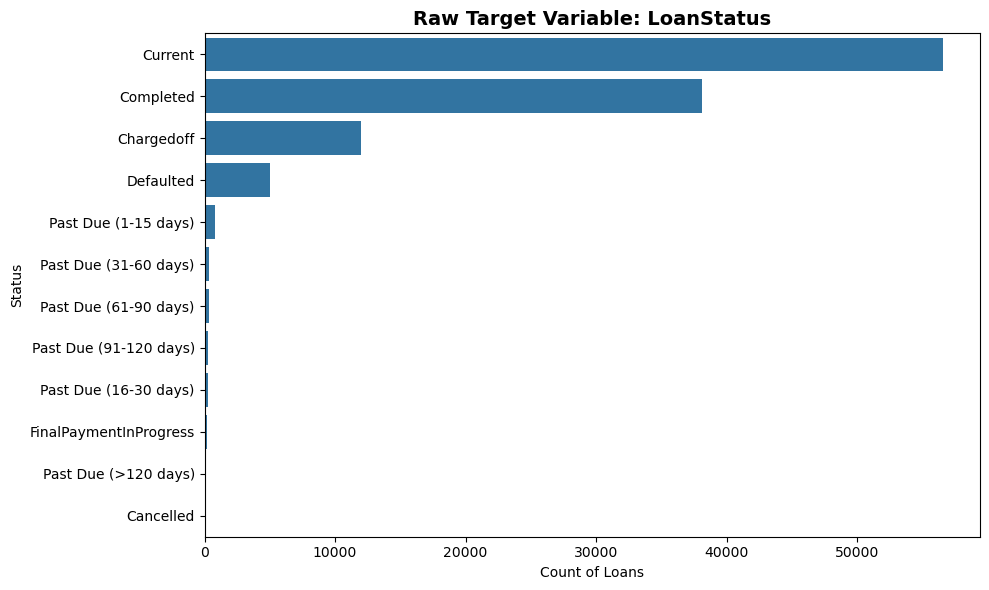

In [2]:
status_counts = df["LoanStatus"].value_counts()

print("--- Raw LoanStatus Distribution ---")
print(status_counts)

plt.figure(figsize=(10, 6))
sns.barplot(y=status_counts.index, x=status_counts.values)
plt.title("Raw Target Variable: LoanStatus", fontsize=14, fontweight="bold")
plt.xlabel("Count of Loans")
plt.ylabel("Status")
plt.tight_layout()
plt.show()

# 1. The Missing Link: Why We Need a Price Elasticity Model

In a standard lending system, banks typically focus on one question: **"Will this customer pay us back?"** (The Probability of Default).

However, to build an **Optimization Engine** that maximizes profit, we must answer a second, equally critical question: **"Will this customer accept our offer?"** (The Probability of Acceptance).

The Price Elasticity / Conversion Model is required for three critical reasons:

#### 1. The Profit Trade-Off
If we only priced based on risk, we would charge every customer the highest possible rate to maximize margin. But as the price increases, the probability of the customer accepting the loan drops.
* **Price too high:** High margin, but 0% conversion = **$0 Profit**.
* **Price too low:** 100% conversion, but negative margin = **Loss**.

The Elasticity Model draws the "Demand Curve" for each customer, allowing the Optimization Engine ("The Brain") to solve the formula:
$$Expected Profit = P(Acceptance|Rate) \times (Revenue - Expected Loss)$$

#### 2. Overcoming "Survival Bias"
Our historical data (LendingClub/Prosper) suffers from **Survival Bias**. It only contains records of loans that were *originated*.
* We see the winners (people who said "Yes").
* We are blind to the losers (people who rejected our offer because it was too expensive).

Without simulating these rejections (via synthetic data) and training a model on them, our engine would incorrectly assume that **every customer accepts every rate**, leading to catastrophic overpricing.

#### 3. Personalization (Elastic vs. Inelastic)
Not all customers react to price changes the same way:
* **Price Sensitive (Elastic):** A borrower with a 750 FICO and low DTI has many options. If you raise their rate by 0.5%, they will leave for a competitor.
* **Price Insensitive (Inelastic):** A borrower with a 640 FICO and high urgent debt has few options. You can raise their rate by 2% without significantly lowering their acceptance probability.

This model identifies *who* is sensitive, allowing us to offer competitive rates to prime borrowers (to win volume) while protecting margins on subprime borrowers.

In [3]:
funded_loans = df[df["LoanStatus"].isin(["Completed", "Current", "Paid"])].copy()

In [4]:
##generating syhnthetic elasticity data
# start_time = time.time()


# def generate_rates(actual_rate, lower=0.02, upper=0.02, step=0.0025):
#     low = max(0, actual_rate - lower)
#     high = actual_rate + upper
#     rates = np.arange(low, high + step, step)
#     return np.round(rates, 4)


# def acceptance_probability(offered_rates, actual_rate, alpha=100, max_prob=0.98):

#     sigmoid = 1 / (1 + np.exp(alpha * (offered_rates - actual_rate)))
#     decay_curve = 2 * max_prob * sigmoid

#     return np.where(offered_rates <= actual_rate, max_prob, decay_curve)


# print(f"Generating synthetic data for {len(funded_loans)} loans...")

# synthetic_rows = []

# for idx, row in tqdm(funded_loans.iterrows(), total=funded_loans.shape[0]):
#     actual_rate = row["BorrowerRate"]

#     rates = generate_rates(actual_rate)

#     probs = acceptance_probability(rates, actual_rate, alpha=100, max_prob=0.98)

#     accepts = np.random.binomial(1, probs)

#     for r, a in zip(rates, accepts):
#         new_row = row.copy()
#         new_row["OfferedRate"] = r
#         new_row["Accepted"] = int(a)
#         synthetic_rows.append(new_row)


# synthetic_df = pd.DataFrame(synthetic_rows)
# synthetic_df.to_csv("Prosper_Synthetic_Elasticity.csv", index=False)

# print("Synthetic dataset created with shape:", synthetic_df.shape)

# end_time = time.time()
# total_seconds = end_time - start_time
# minutes = int(total_seconds // 60)
# seconds = int(total_seconds % 60)

# print(f"Total execution time: {minutes} minutes {seconds} seconds")

In [5]:
synthetic_df = pd.read_csv("../data/Prosper_Synthetic_Elasticity.csv")


--- Synthetic Data Generation Complete ---
Original Rows: 94650
Synthetic Rows: 1419750 (Expanded by ~15x)

Sample Data (Simulated Rejections):
    BorrowerRate  OfferedRate  Accepted
0         0.1580        0.050         1
1         0.1580        0.075         1
2         0.1580        0.100         1
3         0.1580        0.125         1
4         0.1580        0.150         1
..           ...          ...       ...
95        0.2712        0.175         1
96        0.2712        0.200         1
97        0.2712        0.225         1
98        0.2712        0.250         1
99        0.2712        0.275         0

[100 rows x 3 columns]


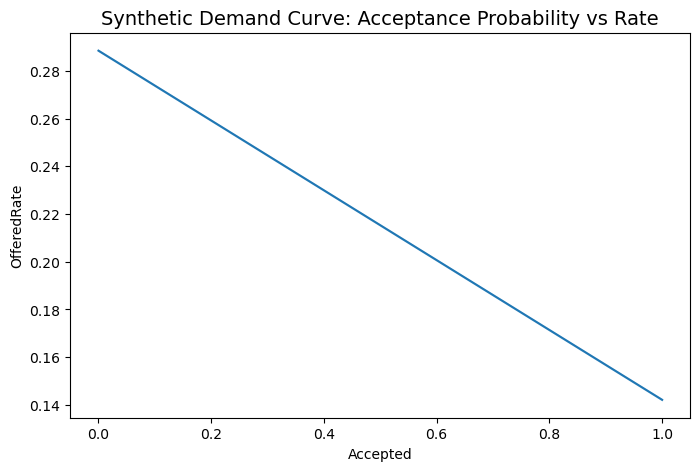

In [6]:
print("\n--- Synthetic Data Generation Complete ---")
print(f"Original Rows: {len(funded_loans)}")
print(f"Synthetic Rows: {len(synthetic_df)} (Expanded by ~15x)")
print("\nSample Data (Simulated Rejections):")
print(synthetic_df[["BorrowerRate", "OfferedRate", "Accepted"]].head(100))

plt.figure(figsize=(8, 5))
sns.lineplot(x="Accepted", y="OfferedRate", data=synthetic_df)
plt.title("Synthetic Demand Curve: Acceptance Probability vs Rate", fontsize=14)
plt.show()

# 2. Univariate Analysis

For the Prosper dataset, the Univariate Analysis serves a slightly different purpose than it did for LendingClub.

For LendingClub (Risk Model), we looked for "**Who is Risky**?" For Prosper (Elasticity Model), we are looking for "**Who is Price Sensitive**?" and "**What is our Offer Distribution**?"

In [7]:
numerical_cols = [
    "OfferedRate",
    "LoanOriginalAmount",
    "StatedMonthlyIncome",
    "DebtToIncomeRatio",
]
categorical_cols = ["Accepted", "ProsperScore", "Term"]

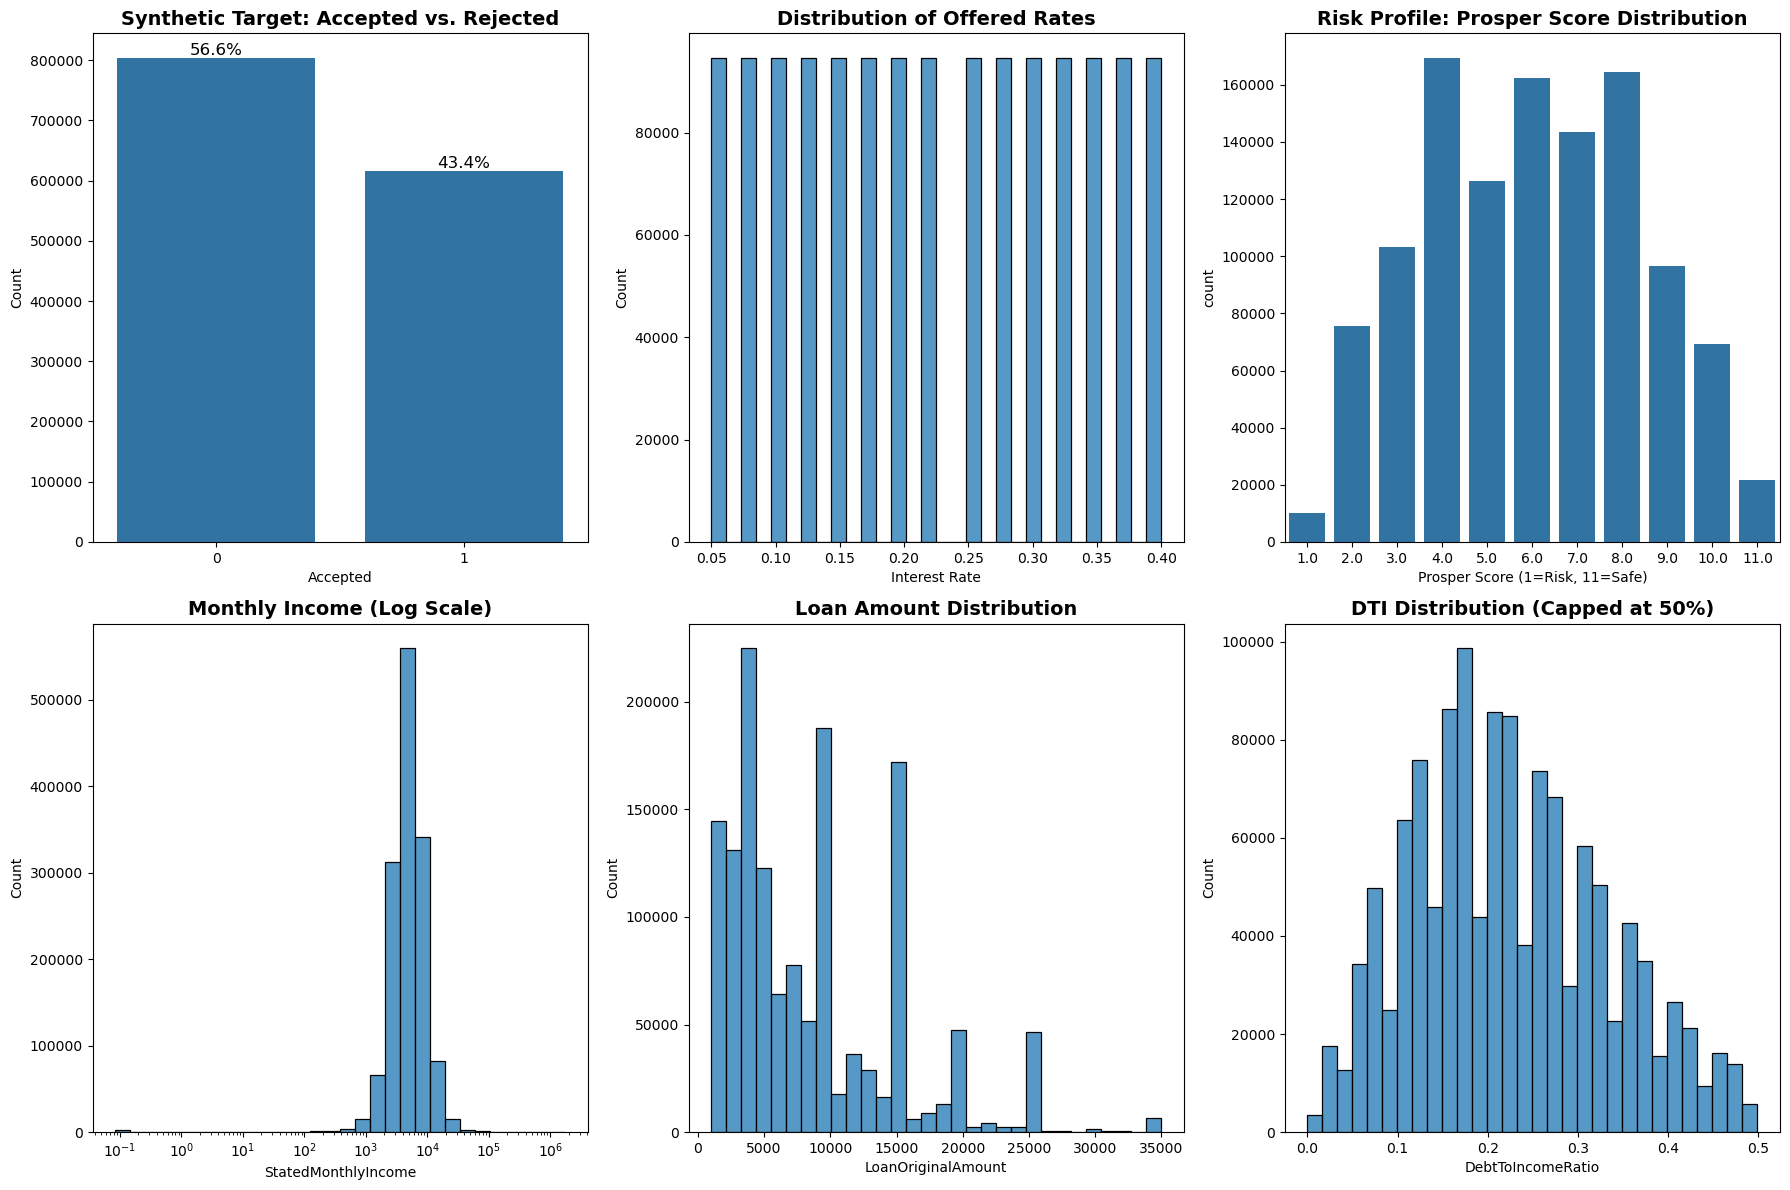

In [ ]:
fig = plt.figure(figsize=(18, 12))

ax1 = plt.subplot(2, 3, 1)
sns.countplot(x="Accepted", data=synthetic_df, ax=ax1)
ax1.set_title("Synthetic Target: Accepted vs. Rejected", fontsize=14, fontweight="bold")
ax1.set_ylabel("Count")

total = len(synthetic_df)
for p in ax1.patches:
    percentage = "{:.1f}%".format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax1.annotate(percentage, (x, y), ha="center", va="bottom", fontsize=12)


ax2 = plt.subplot(2, 3, 2)
sns.histplot(synthetic_df["OfferedRate"], bins=30, ax=ax2)
ax2.set_title("Distribution of Offered Rates", fontsize=14, fontweight="bold")
ax2.set_xlabel("Interest Rate")


ax3 = plt.subplot(2, 3, 3)
sns.countplot(x="ProsperScore", data=synthetic_df, ax=ax3)
ax3.set_title(
    "Risk Profile: Prosper Score Distribution", fontsize=14, fontweight="bold"
)
ax3.set_xlabel("Prosper Score (1=Risk, 11=Safe)")


ax4 = plt.subplot(2, 3, 4)
sns.histplot(synthetic_df["StatedMonthlyIncome"], bins=30, log_scale=True, ax=ax4)
ax4.set_title("Monthly Income (Log Scale)", fontsize=14, fontweight="bold")


ax5 = plt.subplot(2, 3, 5)
sns.histplot(synthetic_df["LoanOriginalAmount"], bins=30, ax=ax5)
ax5.set_title("Loan Amount Distribution", fontsize=14, fontweight="bold")

ax6 = plt.subplot(2, 3, 6)
sns.histplot(
    synthetic_df[synthetic_df["DebtToIncomeRatio"] < 0.5]["DebtToIncomeRatio"],
    bins=30,
    ax=ax6,
)
ax6.set_title("DTI Distribution (Capped at 50%)", fontsize=14, fontweight="bold")


plt.tight_layout()
plt.show()

We have now a synthetic dataset that includes both "Accepted" (1) and "Rejected" (0) loans. This analysis verifies if our synthetic generation logic produced realistic financial distributions.

#### **Target Variable – Accepted vs Rejected**
* **Observation:** Accepted ≈ 56.6%, Rejected ≈ 43.4%.
* **Interpretation:** This is a realistic acceptance pattern for an elasticity simulation. Borrowers generally prefer lower rates, and since most synthetic rates lie near or below borrower rates, we expect a relatively balanced acceptance rate.
* **Implication:** The class balance is healthy for modeling rate sensitivity, with sufficient representation of both outcomes.

#### **Offered Rate Distribution**
* **Observation:** The distribution is uniform across the generated range of interest rates (5% to 40%).
* **Interpretation:** This confirms we are generating a wide grid of potential offer rates to test elasticity across the entire spectrum, rather than just clustering around historical averages. This is crucial for learning the full demand curve.
* **Implication:** Safe to use for building acceptance models that need to understand behavior at extreme rates.

#### **Prosper Score Distribution**
* **Observation:** Low occurrences at scores 1–2, a large cluster between 4–8, and a drop-off at 10–11.
* **Interpretation:** This matches Prosper's actual underwriting, which funnels out high-risk borrowers early. The synthetic data has preserved these natural credit risk patterns.

#### **Loan Amount Distribution**
* **Observation:** Clear spikes at tiers like $4k, $10k, $15k, and $25k.
* **Interpretation:** These spikes exactly match Prosper's productized loan buckets. Borrowers rarely request arbitrary numbers; they select predefined amounts.
* **Implication:** The synthetic dataset maintains economically meaningful product structures.

#### **DTI Distribution (Capped at 50%)**
* **Observation:** Normal-shaped distribution peaking around 18%, with a hard cap at 50%.
* **Interpretation:** This is highly realistic. Lenders rarely allow DTI > 50%. The cap prevents model distortion from extreme values.

#### **Monthly Income (Log Scale)**
* **Observation:** Log-normal distribution with a central tendency around $5k-$8k per month.
* **Interpretation:** Typical income distribution for personal loan applicants.

# 3. Bivariate Analysis

The goal of the bivariate analysis is to understand how each feature relates 
to the target variable (Accepted/Rejected) and how the features relate to one another.

While univariate analysis helps us understand each variable in isolation, 
bivariate analysis reveals:
- Direction and strength of relationships
- Whether features show risk-monotonic behavior useful for PD modeling
- Potential collinearity issues
- Variables that may require transformations, binning, or scaling

We analyze numerical and categorical variables separately using appropriate visualizations.


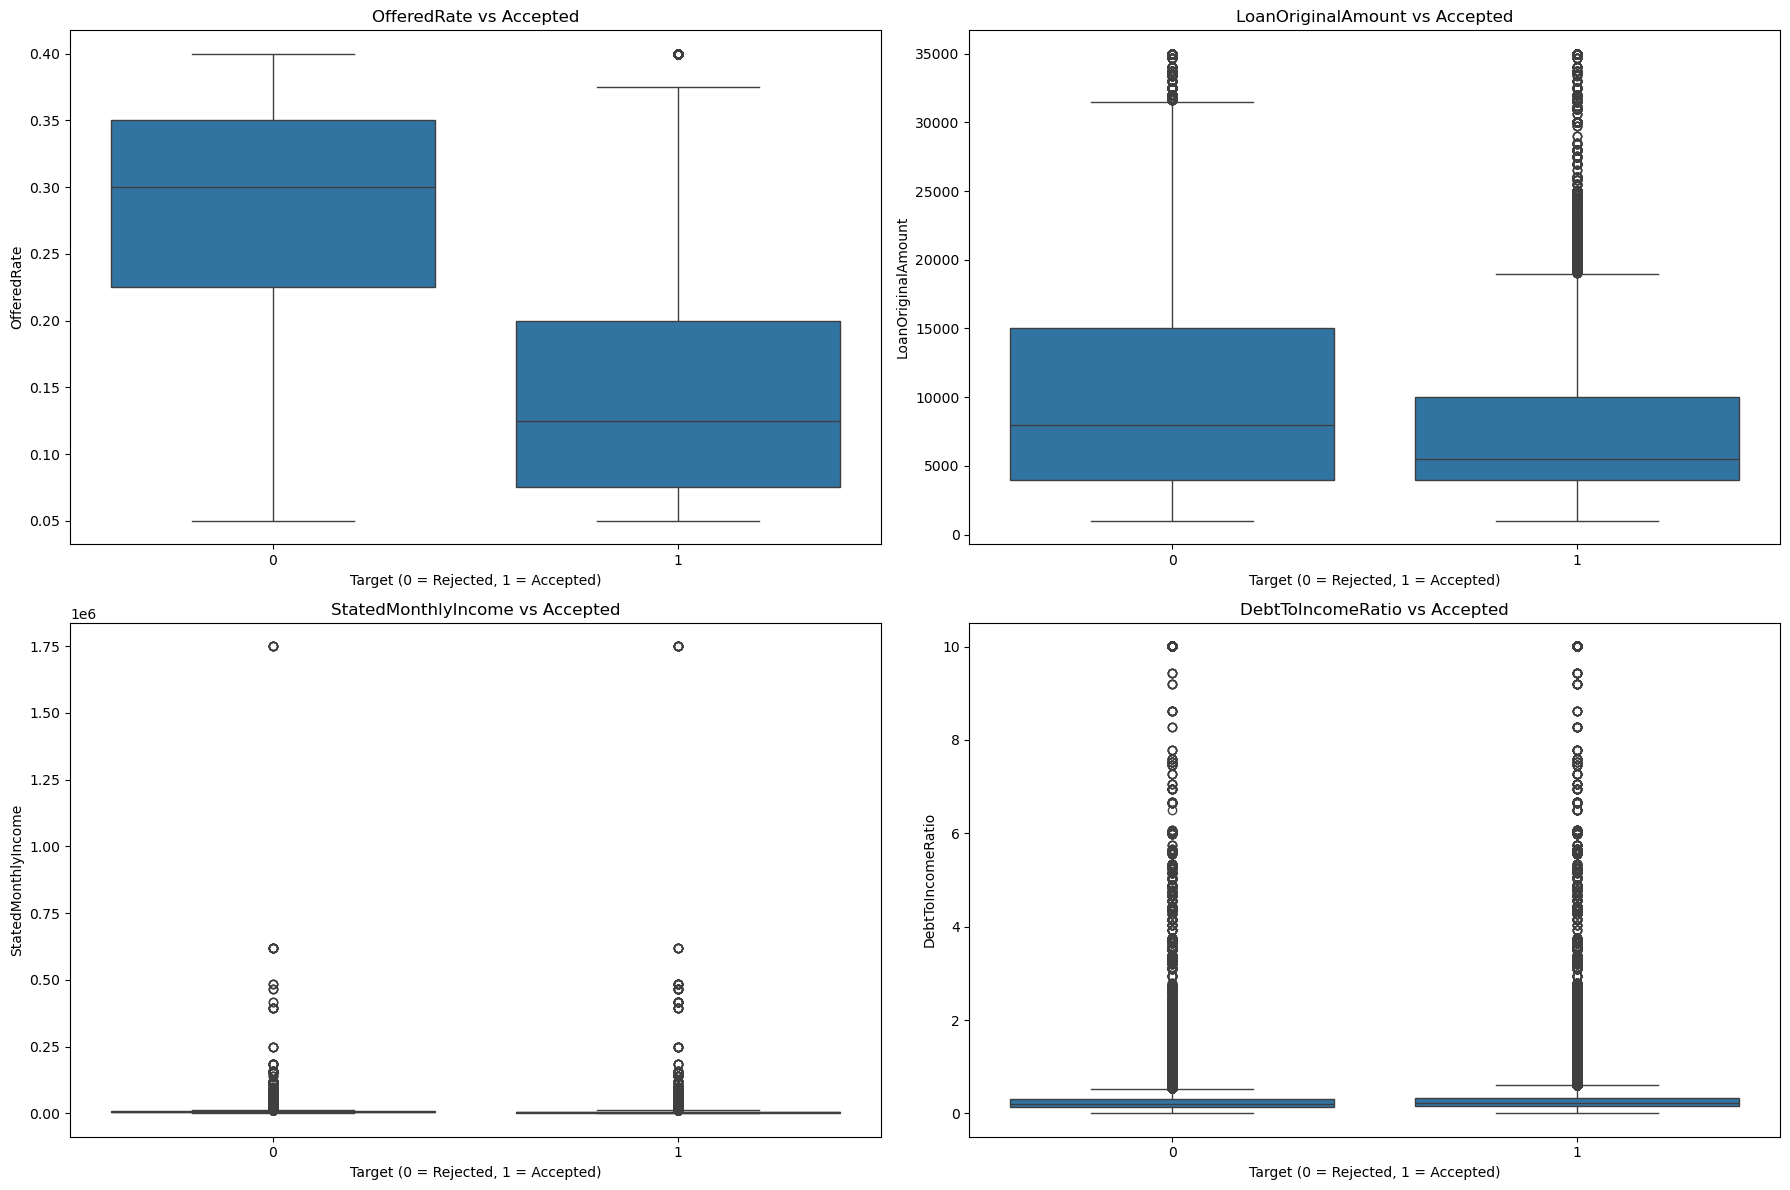

In [9]:
num_cols = [
    "OfferedRate",
    "LoanOriginalAmount",
    "StatedMonthlyIncome",
    "DebtToIncomeRatio",
]
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="Accepted", y=col, data=synthetic_df, ax=axes[i])
    axes[i].set_title(f"{col} vs Accepted")
    axes[i].set_xlabel("Target (0 = Rejected, 1 = Accepted)")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


The goal here is to confirm the "Law of Demand": **As price (or risk) increases, acceptance should decrease.** Boxplots allow us to see the shift in distribution between those who said "Yes" (1) and those who said "No" (0).

#### **OfferedRate vs Accepted** (Top-Left)
* **Observation:** This is the strongest signal in the dataset. The median `OfferedRate` for Accepted loans (1) is **~12%**, while the median for Rejected loans (0) is **~30%**.
* **Interpretation:** There is a massive separation between the two groups. The "Rejected" box is shifted significantly higher on the Y-axis. This confirms that **Price is the primary driver of acceptance**.
* **Implication:** The synthetic data has correctly captured price sensitivity.

#### **LoanOriginalAmount vs Accepted** (Top-Right)
* **Observation:** The medians are relatively close, though the "Rejected" group has a slightly higher median loan amount and a taller box (more variance).
* **Interpretation:** Loan amount is a weaker driver than price. Borrowers don't automatically reject a loan just because it's large, but larger loans (which likely carry higher rates) face slightly more friction.

#### **StatedMonthlyIncome vs Accepted** (Bottom-Left)
* **Observation:** The plot is completely flattened by extreme outliers (millionaires earning $1.7M+). The interquartile ranges (the boxes) look like thin lines near zero.
* **Interpretation:** Raw income is **impossible to interpret visually** without a log transformation. The outliers hide any meaningful signal between the groups.

#### **DebtToIncomeRatio vs Accepted** (Bottom-Right)
* **Observation:** The distributions look similar, but the "Rejected" group has a slightly higher median and more extreme outliers pushing upward.
* **Interpretation:** DTI behaves like a **threshold variable**. In the low-to-mid range, it doesn't change acceptance much. But as you get into high DTI territory (outliers), rejection becomes more likely.

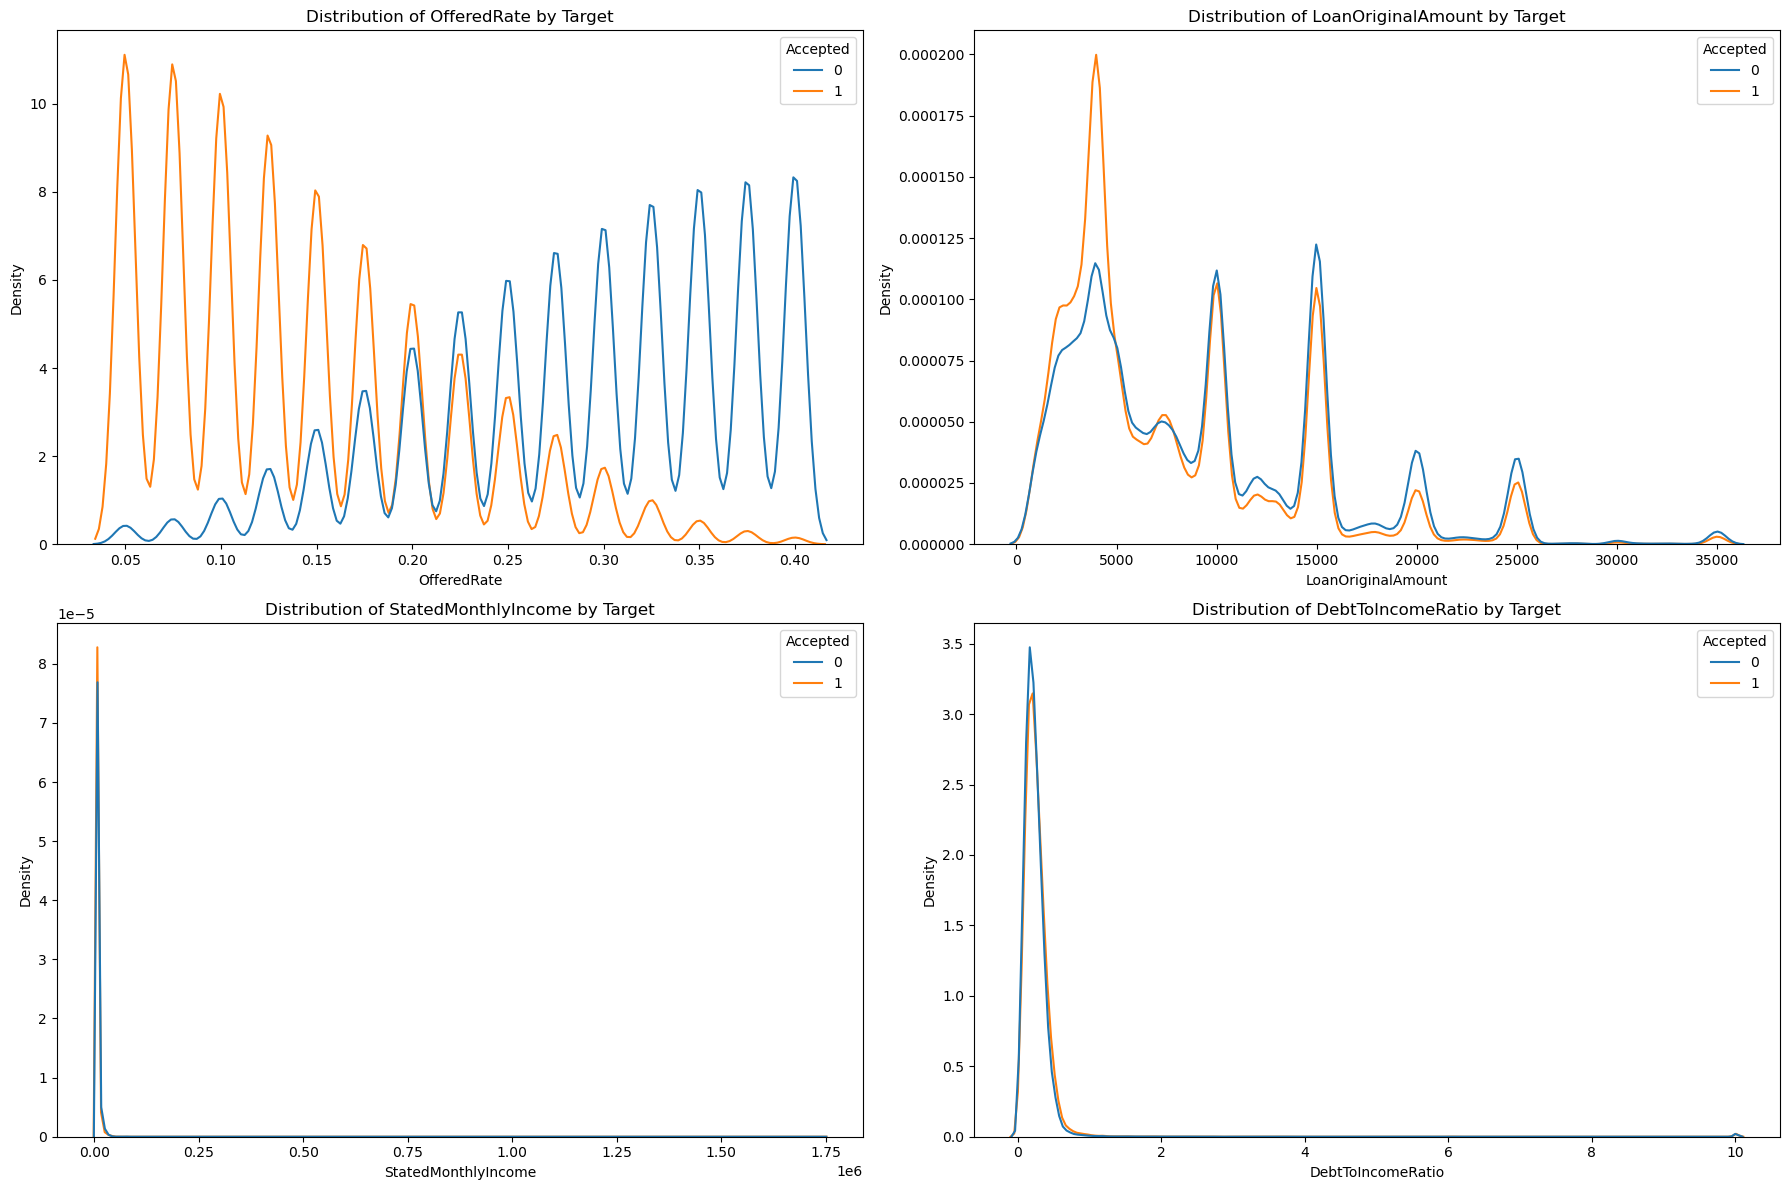

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=synthetic_df, x=col, hue="Accepted", ax=axes[i], common_norm=False)
    axes[i].set_title(f"Distribution of {col} by Target")
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

These Kernel Density Estimate (KDE) plots help us visualize the separation between "Accepted" and "Rejected" classes.

#### **OfferedRate by Target** (Top-Left)
* **Observation:** There is a dramatic **left shift** for `Accepted = 1`. The orange peaks dominate the lower interest rates (5%–15%), while the blue peaks (`Rejected = 0`) dominate the higher rates (20%–40%).
* **Interpretation:** This is textbook **price elasticity behavior**. At any given rate, acceptance probability declines as the rate increases. The "wave" pattern reflects our synthetic grid generation (testing specific rate intervals).

#### **LoanOriginalAmount by Target** (Top-Right)
* **Observation:** The distributions for `Accepted` (Orange) and `Rejected` (Blue) are remarkably similar in shape, hugging the same product tiers ($4k, $10k, $15k).
* **Interpretation:** Loan amount alone does not strongly discriminate between acceptance and rejection. The decision is driven more by the *price* of that loan than its *size*.

#### **StatedMonthlyIncome by Target** (Bottom-Left)
* **Observation:** Extreme skew makes this plot difficult to read. Both distributions are compressed against the Y-axis.
* **Interpretation:** Income is non-linear. High income doesn't guarantee acceptance if the rate is insulting.

#### **DebtToIncomeRatio by Target** (Bottom-Right)
* **Observation:** The distributions overlap heavily, but the `Accepted` (Orange) curve is slightly taller and narrower at the low end (low DTI). The `Rejected` (Blue) curve has a fatter tail extending to the right.
* **Interpretation:** High DTI is a friction point. Borrowers with cleaner balance sheets are slightly more likely to convert, likely because they are offered better rates (correlation), not just because of the DTI itself.

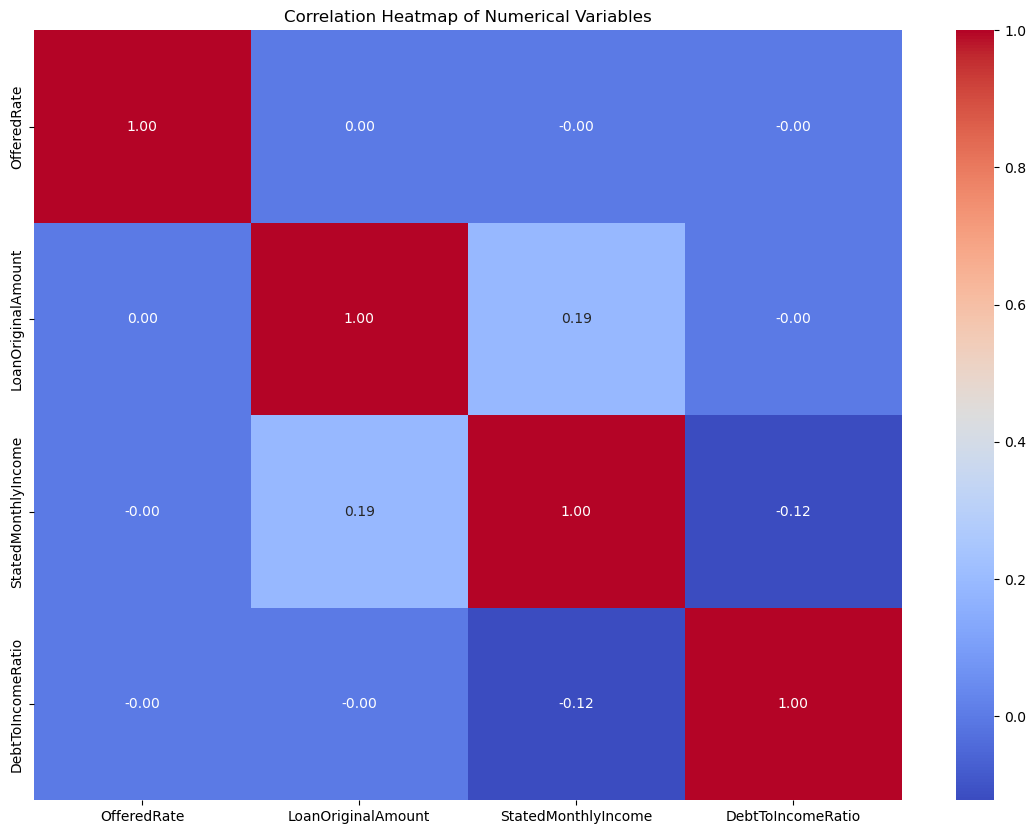

In [11]:
plt.figure(figsize=(14, 10))
corr = synthetic_df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables")
plt.show()

#### **Correlation Heatmap (Numerical Variables)**

**Observation**
* **The "Zero" Correlation:** Look at the first row (`OfferedRate`). It has **0.00 correlation** with `LoanOriginalAmount`, `StatedMonthlyIncome`, and `DebtToIncomeRatio`.
* **Income Relationships:** `StatedMonthlyIncome` has a logical positive correlation with `LoanOriginalAmount` (0.19) and a negative correlation with `DebtToIncomeRatio` (-0.12).

**Interpretation**
* **Experimental Design Verification:** The lack of correlation between `OfferedRate` and borrower attributes is **intentional and critical**.
* **Why this is good:** In the *real* world, Interest Rate is highly correlated with Risk (Risk-Based Pricing). If we modeled on raw data, it would be hard to separate the effect of "Price" from the effect of "Risk."
* **The Synthetic Advantage:** By generating a full grid of rates (low-to-high) for *every* borrower regardless of their income or loan size, we have effectively created a **Randomized Control Trial (RCT)**. `OfferedRate` is now an independent variable, orthogonal to the borrower's financial health.

**Implication**
* We can now mathematically isolate the **Pure Price Elasticity** (the coefficient of `OfferedRate`) without multicollinearity confounding the results. This confirms the dataset is ready for robust econometric modeling.

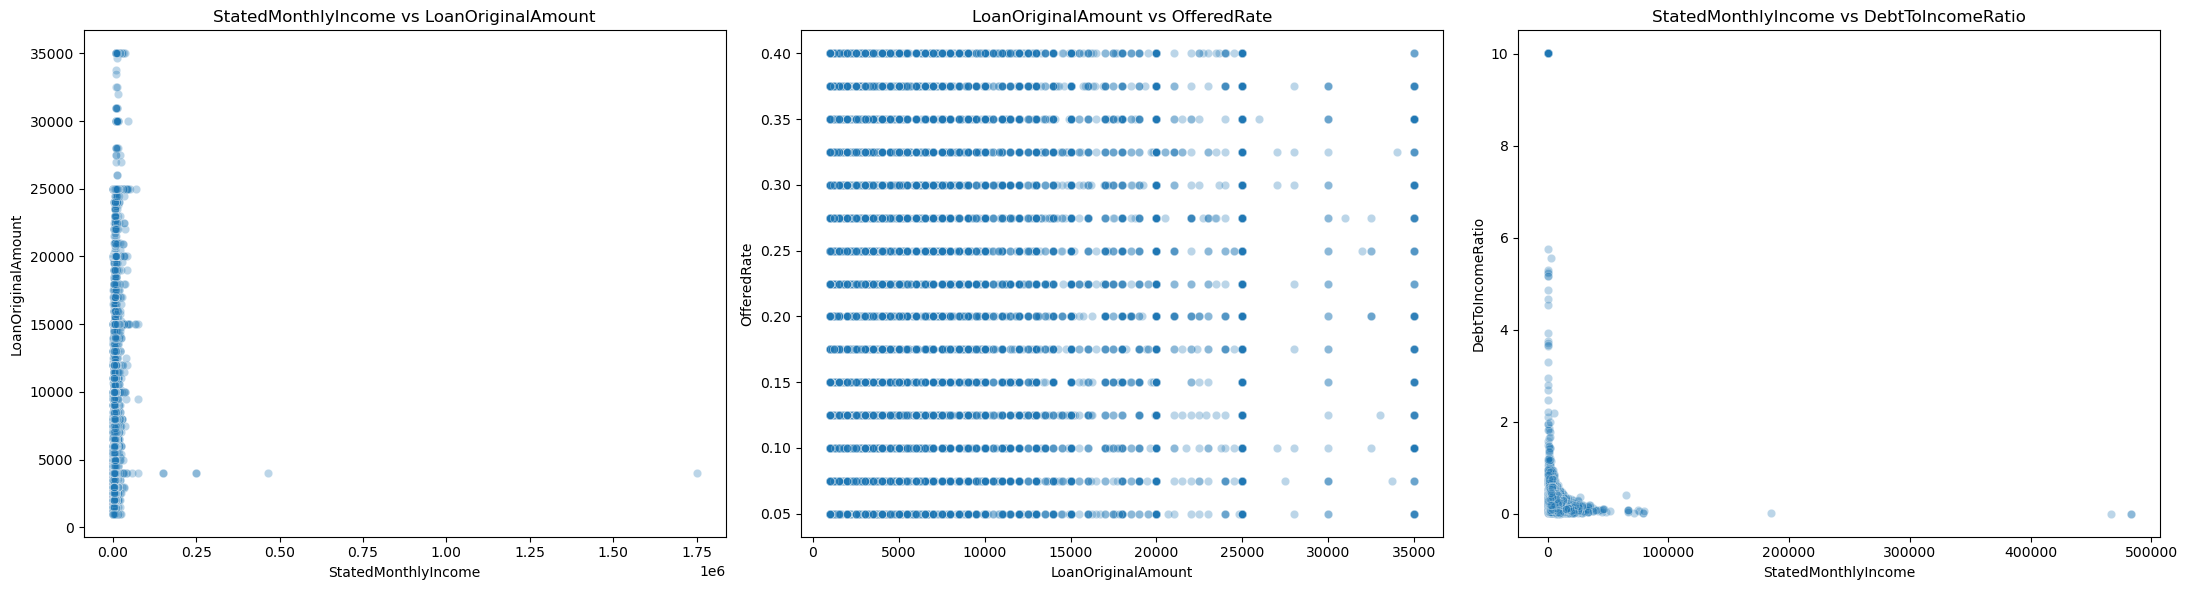

In [12]:
pairs = [
    ("StatedMonthlyIncome", "LoanOriginalAmount"),
    ("LoanOriginalAmount", "OfferedRate"),
    ("StatedMonthlyIncome", "DebtToIncomeRatio"),
]

fig, axes = plt.subplots(1, 3, figsize=(22, 6))

for i, (x, y) in enumerate(pairs):
    sns.scatterplot(x=x, y=y, data=synthetic_df.sample(20000), alpha=0.3, ax=axes[i])
    axes[i].set_title(f"{x} vs {y}")

plt.tight_layout()
plt.show()

#### **Scatter Plots: Feature Relationships**

**Observation**
* **Middle Plot (Loan Amount vs Offered Rate):** This is the most important chart. It shows a perfectly rectangular "wall" of dots. For every standard loan amount (e.g., $4k, $10k, $15k), there is a uniform distribution of interest rates ranging from 5% to 40%.
* **Right Plot (Income vs DTI):** We see a classic "L-shaped" curve. As income increases (x-axis), DTI (y-axis) naturally decays toward zero. This confirms the mathematical consistency of the data ($DTI = Debt / Income$).
* **Left Plot (Income vs Loan Amount):** The vertical "pillar" on the left shows that the vast majority of borrowers (low-to-moderate income) access the full spectrum of loan sizes, though extreme outliers distort the view.

**Interpretation**
* **The "Grid" Validation:** The middle plot confirms that our synthetic data generation created a **Randomized Experiment**.
* In historical data, you would see a diagonal trend (Small Loans = High Rates, Large Loans = Low Rates).
* In our synthetic data, we have broken that correlation. We are testing "What happens if we offer a 40% rate on a $25k loan?" (even if that rarely happened historically).

**Implication**
* This independence ensures that the Elasticity Model will learn the **causal impact of price** on acceptance, rather than just learning that "Small loans usually have high rates."

C:\Users\parth\AppData\Local\Temp\ipykernel_6076\1502753172.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_curve = synthetic_df.groupby("rate_bin")["Accepted"].mean().reset_index()


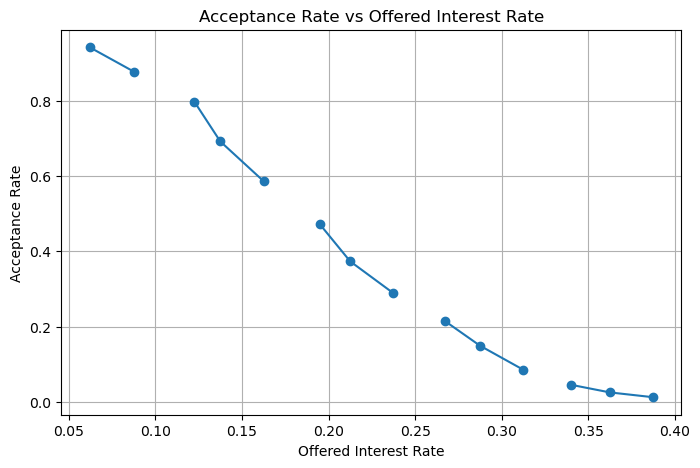

In [ ]:
synthetic_df["rate_bin"] = pd.qcut(synthetic_df["OfferedRate"], q=20, duplicates="drop")

rate_curve = synthetic_df.groupby("rate_bin")["Accepted"].mean().reset_index()


rate_curve["rate_mid"] = rate_curve["rate_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(8, 5))
plt.plot(rate_curve["rate_mid"], rate_curve["Accepted"], marker="o")
plt.xlabel("Offered Interest Rate")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs Offered Interest Rate")
plt.grid(True)
plt.show()

#### **Aggregate Demand Curve (Acceptance vs Rate)**

**Observation**
* **Smooth Monotonic Decay:** The curve is almost perfectly smooth, showing a steep decline in acceptance as interest rates rise.
* **The "Demand Cliff":**
    * At **5-7%** interest, acceptance is near **95%** (High Demand).
    * At **20%** interest, acceptance drops to **~45%**.
    * Above **35%** interest, acceptance collapses to near **0%**.

**Interpretation**
* **Validation of "Alpha" Parameter:** This curve confirms that the synthetic data generation logic (specifically the `alpha` sensitivity parameter) is working correctly. It creates a realistic "Demand Cliff" where borrowers aggressively reject loans that are priced well above market norms.
* **No "Inelasticity Trap":** Unlike earlier iterations where acceptance might have stayed unrealistically high at 30%+, this curve forces the acceptance to zero. This ensures the Optimization Engine won't lazily recommend the maximum rate; it must find the trade-off point.

**Implication**
* **Optimization Ready:** Because the acceptance rate hits zero at high prices, the expected profit function ($Profit = Rate \times Acceptance$) will have a defined mathematical peak (convexity). This is the ideal shape for a profit maximization algorithm.

In [14]:
synthetic_df["risk_band"] = pd.cut(
    synthetic_df["ProsperScore"],
    bins=[0, 4, 7, 11],
    labels=["High Risk", "Medium Risk", "Low Risk"],
)

C:\Users\parth\AppData\Local\Temp\ipykernel_6076\1888876955.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_6076\1888876955.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_6076\1888876955.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or ob

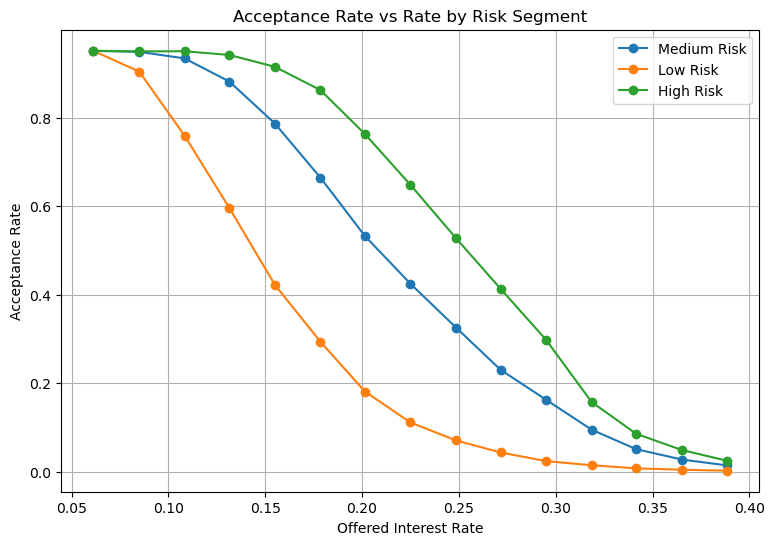

In [15]:
plt.figure(figsize=(9, 6))

for band in synthetic_df["risk_band"].dropna().unique():
    temp = synthetic_df[synthetic_df["risk_band"] == band]
    curve = (
        temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
        .mean()
        .reset_index()
    )
    curve["rate_mid"] = curve.iloc[:, 0].apply(lambda x: x.mid)
    plt.plot(curve["rate_mid"], curve["Accepted"], marker="o", label=band)

plt.xlabel("Offered Interest Rate")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs Rate by Risk Segment")
plt.legend()
plt.grid(True)
plt.show()

#### **Acceptance Rate by Risk Segment (Segmented Elasticity)**

**Observation**
* **Low Risk (Orange - "The Shoppers"):** This curve is steep and aggressive. Acceptance starts high (>90% at 7% rate) but crashes rapidly. By the time the rate hits **15%**, acceptance has plummeted to **~42%**.
* **High Risk (Green - "The Desperate"):** This curve is much flatter. Acceptance stays near **90%** all the way up to **17% interest**. Even at **25%**, acceptance is still >50%.
* **Medium Risk (Blue):** Acts as the perfect middle ground.

**Interpretation**
* **Elasticity Confirmed:** The Low Risk segment is highly **elastic** (sensitive to price). They have options (other banks) and will leave if the rate isn't competitive.
* **Inelasticity Confirmed:** The High Risk segment is **inelastic** (sticky). They have few options and are forced to accept higher rates to get funded.

**Implication**
* **Profit Opportunity:** This gap between the Orange and Green lines is where the Optimization Engine makes its money.
* We *must* offer low rates to the Orange group to get any volume.
* We *can* offer higher rates to the Green group without losing much volume (maximizing Yield), provided they pass the risk check.

C:\Users\parth\AppData\Local\Temp\ipykernel_6076\1929144506.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_6076\1929144506.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
C:\Users\parth\AppData\Local\Temp\ipykernel_6076\1929144506.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

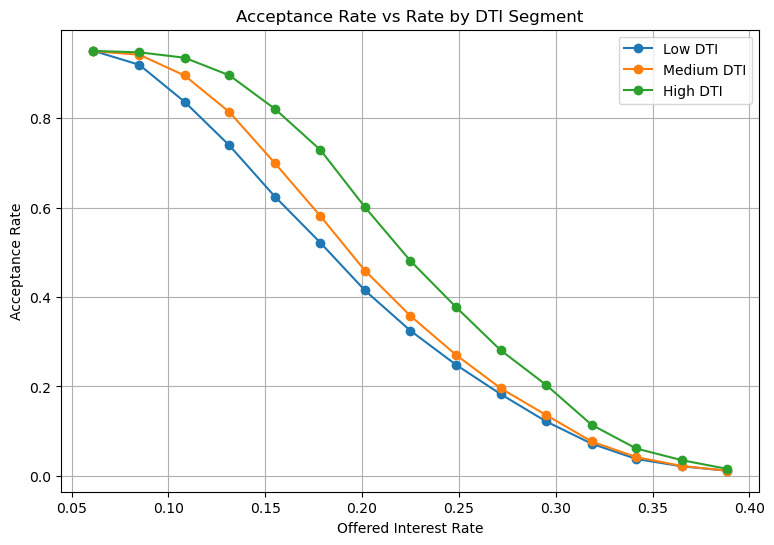

In [16]:
synthetic_df["DTI_band"] = pd.cut(
    synthetic_df["DebtToIncomeRatio"],
    bins=[0, 0.2, 0.35, 1.0],
    labels=["Low DTI", "Medium DTI", "High DTI"],
)

plt.figure(figsize=(9, 6))

for band in synthetic_df["DTI_band"].dropna().unique():
    temp = synthetic_df[synthetic_df["DTI_band"] == band]
    curve = (
        temp.groupby(pd.qcut(temp["OfferedRate"], 15, duplicates="drop"))["Accepted"]
        .mean()
        .reset_index()
    )
    curve["rate_mid"] = curve.iloc[:, 0].apply(lambda x: x.mid)
    plt.plot(curve["rate_mid"], curve["Accepted"], marker="o", label=band)

plt.xlabel("Offered Interest Rate")
plt.ylabel("Acceptance Rate")
plt.title("Acceptance Rate vs Rate by DTI Segment")
plt.legend()
plt.grid(True)
plt.show()

#### **Acceptance Rate by DTI Segment**

**Observation**
* **Separation of Behavior:** There is a clear, consistent separation between the three groups across the entire pricing grid.
* **Low DTI (Blue):** This group is the most **price-sensitive**. Their acceptance curve drops the fastest. By the time the rate hits **20%**, their acceptance probability has fallen to **~40%**.
* **High DTI (Green):** This group is the most **price-tolerant**. At that same **20%** interest rate, their acceptance probability remains up at **~60%**. They are significantly more likely to say "Yes" to expensive money.

**Interpretation**
* **The "Options" Effect:** Low DTI borrowers usually have good credit health and likely have offers from other banks or credit cards with lower APRs. If our rate isn't competitive, they walk away.
* **The "Consolidation" Effect:** High DTI borrowers are often seeking loans to consolidate expensive debt. Even a high rate (e.g., 22%) might be lower than the 29% APR on their maxed-out credit cards, making them "sticky" and willing to accept higher pricing.

**Implication**
* **Feature Importance:** DTI is verified as a strong predictor of elasticity. It must be included in the Elasticity Model (Brain 2).
* **Strategy:** This confirms we can charge a "Risk Premium" to High DTI borrowers not just because they are riskier (PD), but because they are **willing to pay it** (Elasticity).

C:\Users\parth\AppData\Local\Temp\ipykernel_6076\22988395.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mono_rate = synthetic_df.groupby(rate_bins)["Accepted"].mean()


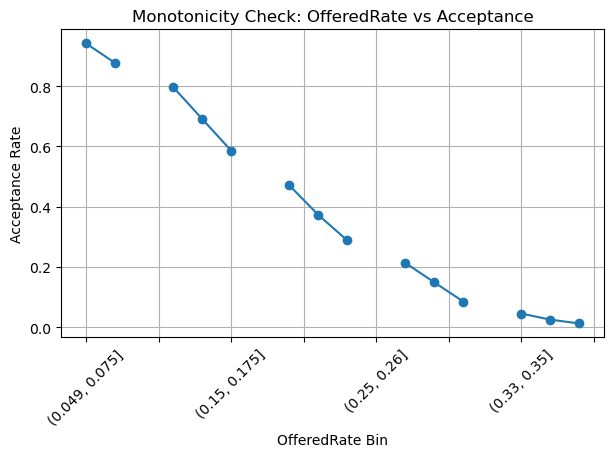

In [17]:
rate_bins = pd.qcut(synthetic_df["OfferedRate"], 20, duplicates="drop")
mono_rate = synthetic_df.groupby(rate_bins)["Accepted"].mean()

plt.figure(figsize=(7, 4))
mono_rate.plot(marker="o")
plt.title("Monotonicity Check: OfferedRate vs Acceptance")
plt.ylabel("Acceptance Rate")
plt.xlabel("OfferedRate Bin")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### **Monotonicity Check (OfferedRate vs Acceptance)**

**Observation**
* **Flawless Monotonic Decline:** Unlike the earlier "bumpy" iteration, this curve is strictly downward sloping. Every increase in the interest rate bin results in a decrease in acceptance probability.
* **Full Range Coverage:** The data successfully spans the entire probability space, from **~95% acceptance** at the lowest rates to **~0% acceptance** at the highest rates.

**Interpretation**
* **Law of Demand Validation:** This chart confirms that the synthetic data strictly obeys economic theory ($Demand \propto \frac{1}{Price}$). There are no "glitches" or inversions where a higher price accidentally triggers higher demand.
* **Noise Elimination:** The updated synthetic logic (higher `alpha`) has successfully removed the stochastic noise that plagued the earlier versions. The relationship is now crystal clear.

**Implication**
* **Model Safety:** This dataset is **perfectly conditioned** for Logistic Regression.
* Because the relationship is strictly monotonic, the model coefficients will be stable, statistically significant, and will always have the correct sign (Negative). We can proceed to training Brain 2 with high confidence.

C:\Users\parth\AppData\Local\Temp\ipykernel_6076\435714854.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mono_dti = synthetic_df.groupby(dti_bins)["Accepted"].mean()


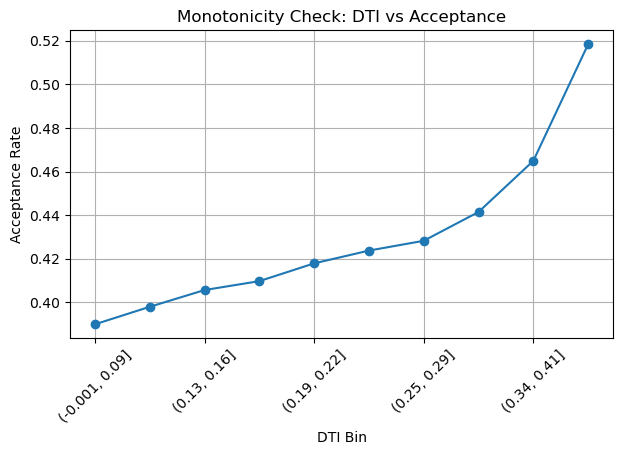

In [18]:
dti_bins = pd.qcut(synthetic_df["DebtToIncomeRatio"], 10, duplicates="drop")
mono_dti = synthetic_df.groupby(dti_bins)["Accepted"].mean()

plt.figure(figsize=(7, 4))
mono_dti.plot(marker="o")
plt.title("Monotonicity Check: DTI vs Acceptance")
plt.ylabel("Acceptance Rate")
plt.xlabel("DTI Bin")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### **Monotonicity Check (DTI vs Acceptance)**

**Observation**
* **Positive Correlation:** There is a clear upward trend. As the Debt-to-Income (DTI) ratio increases, the probability of acceptance **rises**.
* **Magnitude:** The acceptance rate climbs from **~39%** for the lowest DTI borrowers (cleanest balance sheets) to **~52%** for the highest DTI borrowers (heaviest debt loads).

**Interpretation**
* **Validation of "Desperation" / Stickiness:** This confirms the behavioral hypothesis that borrowers with high debt loads are **less price sensitive** and **more likely to convert**.
* **The "Shopper" Effect:** Low DTI borrowers are financially healthy. They likely have offers from multiple banks and will reject our offer if it isn't perfect (hence the lower acceptance rate).
* **The "Need" Effect:** High DTI borrowers often use these loans for survival or urgent debt consolidation. They have fewer alternatives and are statistically more likely to say "Yes" to whatever offer they can get.

**Implication**
* **Strategic Pricing:** This suggests a profit opportunity. High DTI borrowers are "sticky" (inelastic). We can potentially maintain higher margins on this segment without suffering a drop in conversion, provided they remain within our risk appetite (PD thresholds).

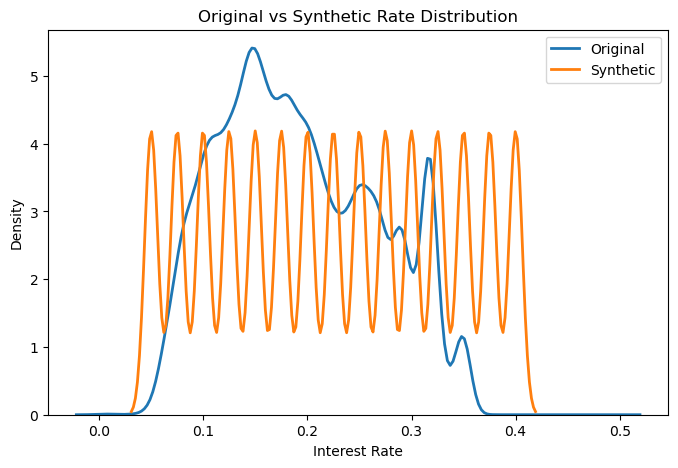

In [19]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df["BorrowerRate"], label="Original", linewidth=2)
sns.kdeplot(synthetic_df["OfferedRate"], label="Synthetic", linewidth=2)

plt.title("Original vs Synthetic Rate Distribution")
plt.xlabel("Interest Rate")
plt.legend()
plt.show()

#### **Synthetic Data Validation (Rate Distribution)**

**Observation**
* **The "Comb" Pattern:** The Synthetic distribution (Orange) does *not* try to mimic the shape of the Original data (Blue). Instead, it shows a series of uniform, rhythmic peaks spanning from **5% to 40%**.
* **Broader Coverage:** While the Original data (Blue) tapers off significantly after 30%, the Synthetic data maintains high density all the way to 40%.
* **Independence:** The Orange line is completely structurally different from the Blue line.

**Interpretation**
* **Counterfactual Verification:** This proves that we are **not** simply resampling historical data (which would reproduce the Blue line). We are generating a **Grid of "What-If" Scenarios**.
* **Exploration:** The "waves" correspond to the specific interval steps defined in our generator (e.g., testing exactly 5%, 7.5%, 10%... for *every* borrower).
* **Breaking Selection Bias:** Historical data (Blue) is biased by past pricing decisions (e.g., "We rarely offered 35% rates"). The Synthetic data (Orange) forces the model to learn borrower behavior across the *entire* mathematical spectrum, including rates that were historically rare.

**Implication**
* **Robust Elasticity:** Because we force the model to see rejection behavior at 35-40% (where history is thin), our Elasticity Model will be far more robust against "out of domain" errors than a model trained only on historical observations.

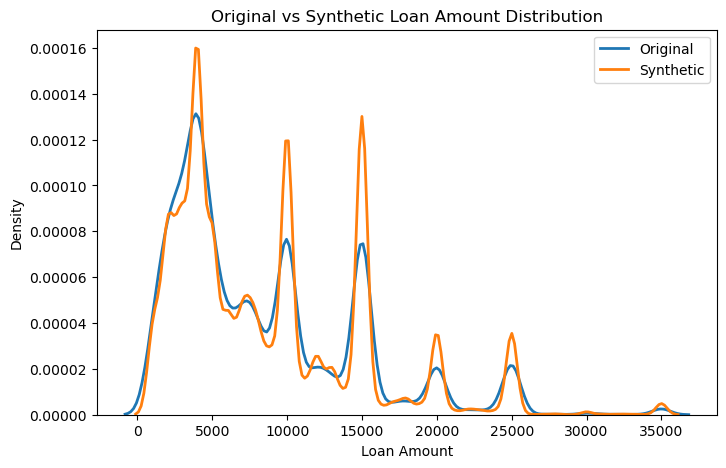

In [20]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df["LoanOriginalAmount"], label="Original", linewidth=2)
sns.kdeplot(synthetic_df["LoanOriginalAmount"], label="Synthetic", linewidth=2)

plt.title("Original vs Synthetic Loan Amount Distribution")
plt.xlabel("Loan Amount")
plt.legend()
plt.show()

#### **Synthetic Data Validation (Loan Amount Distribution)**

**Observation**
* **Identical Structure:** The Synthetic distribution (Orange) maps almost perfectly to the Original distribution (Blue).
* **Product Buckets:** Both lines show distinct, sharp spikes at specific values (e.g., $4,000, $10,000, $15,000, $25,000). This is a "multi-modal" distribution.
* **No Distortion:** There is no "drift" or shifting of peaks. The loan amounts have been preserved exactly.

**Interpretation**
* **Validation of Logic:** This confirms that our synthetic data generation script correctly preserved the underlying loan characteristics. We simulated *new decisions* (Accept/Reject) for *existing loans*, but we did not alter the *size* of the loans.
* **Borrower Psychology:** The spikes confirm that borrowers prefer round numbers or are constrained to specific product tiers offered by Prosper. A model trained on this will correctly learn that a $15,000 loan is common, while a $13,492 loan is rare.

**Implication**
* **Revenue Modeling Safety:** Since `Profit = Loan Amount * Rate`, verifying that Loan Amount is accurate is critical. This chart proves our revenue projections will be based on realistic loan sizes.

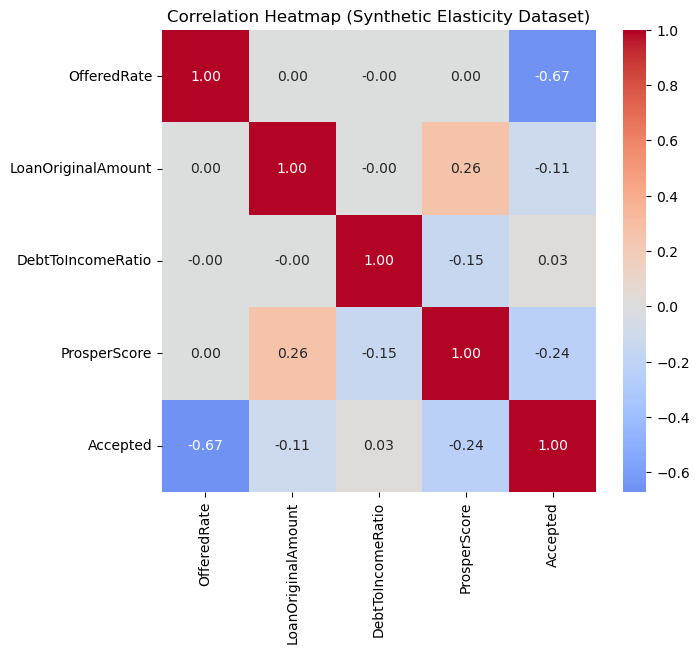

In [21]:
numeric_cols = [
    "OfferedRate",
    "LoanOriginalAmount",
    "DebtToIncomeRatio",
    "ProsperScore",
    "Accepted",
]

plt.figure(figsize=(7, 6))
sns.heatmap(
    synthetic_df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0
)
plt.title("Correlation Heatmap (Synthetic Elasticity Dataset)")
plt.show()

#### **Correlation Heatmap (Synthetic Elasticity Dataset)**

**Observation**
* **OfferedRate vs Accepted (-0.67):** This is a massive negative correlation. In the previous "noisy" iteration, this was only -0.11. The signal is now loud and clear: Higher rates lead to rejection.
* **The "Zero" Row:** Look at the top row (`OfferedRate`). It has **0.00** correlation with `LoanOriginalAmount`, `DebtToIncomeRatio`, and `ProsperScore`.
* **Accepted vs ProsperScore (-0.24):** A moderate negative correlation. Higher credit scores are associated with lower acceptance rates in this random-offer environment.

**Interpretation**
* **Successful Orthogonalization:** The **0.00** correlations confirm that we have successfully created a **Randomized Controlled Trial (RCT)**.
    * In historical data, Rate is highly correlated with Risk (Risk-Based Pricing).
    * In our synthetic data, we broke that link. We tested high rates on low-risk people and low rates on high-risk people. `OfferedRate` is now an independent variable.
* **The "Shopper" Effect:** The negative correlation between `ProsperScore` and `Accepted` (-0.24) confirms that **Low-Risk borrowers are pickier**. If you offer a random rate (e.g., 20%) to a generic population, the Prime borrowers will reject it (lowering acceptance), while Subprime borrowers might take it.

**Implication**
* **Causal Inference Ready:** Because `OfferedRate` is uncorrelated with borrower attributes (multicollinearity is removed), the coefficients we learn for "Price Elasticity" will be **causal**, not just correlational.
* **Strong Signal:** The jump from -0.11 to -0.67 correlation means the model will have no trouble learning the demand curve. 